In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.manual_seed(42)

## Organizing Data


In [42]:
from google.colab import drive
drive.mount('/content/drive')

file_path_ball = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToBall_full_obs_50ktasks.pt'
ball = torch.load(file_path_ball, weights_only=False)

file_path_basket = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToBasket_full_obs_50ktasks.pt'
basket = torch.load(file_path_basket, weights_only=False)

file_path_bin = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToBin_full_obs_50ktasks.pt'
bin = torch.load(file_path_bin, weights_only=False)

file_path_book = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToBook_full_obs_50ktasks.pt'
book = torch.load(file_path_book, weights_only=False)

file_path_box = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToBox_full_obs_50ktasks.pt'
box = torch.load(file_path_box, weights_only=False)

file_path_cupboard = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToCupboard_full_obs_50ktasks.pt'
cupboard = torch.load(file_path_cupboard, weights_only=False)

file_path_shelf = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToShelf_full_obs_50ktasks.pt'
shelf = torch.load(file_path_shelf, weights_only=False)

file_path_stick = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToStick_full_obs_50ktasks.pt'
stick = torch.load(file_path_stick, weights_only=False)

file_path_tray = '/content/drive/My Drive/DiffusionModel/Experiment/Data/NavigateToTray_full_obs_50ktasks.pt'
tray = torch.load(file_path_tray, weights_only=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### The General Dataset (World)

Extract the states, actions, idx and slit them into test and train

In [44]:
device = torch.device("cuda")

def organize(data):

    states = data['states']
    actions = data['actions']
    idx = data['train_task_idxs']
    idx = idx.reshape(-1, 1)

    data_new = np.hstack((states, actions, idx))
    data_new = torch.tensor(data_new, dtype=torch.float32).to(device)

    return data_new

def shuffle_and_split(data, training_size, test_size, random_seed=42):
    if random_seed is not None:
        np.random.seed(random_seed)

    task_idx = data[:, -1].cpu()
    states = data[:, 0:-3]
    actions = data[:, -3:-1]

    # Get unique task indexes and shuffle them
    unique_tasks = np.unique(task_idx)
    np.random.shuffle(unique_tasks)

    # Split into train and test tasks
    train_tasks = unique_tasks[:training_size]
    test_tasks = unique_tasks[training_size:training_size + test_size]

    # Create masks for train and test sets
    train_mask = np.isin(task_idx, train_tasks)
    test_mask = np.isin(task_idx, test_tasks)

    # Split the dataset
    states_train, actions_train, task_idx_train = states[train_mask], actions[train_mask], task_idx[train_mask]
    states_test, actions_test, task_idx_test = states[test_mask], actions[test_mask], task_idx[test_mask]

    return (states_train, actions_train, task_idx_train), (states_test, actions_test, task_idx_test)


def check_overlapping(task_idx_1, task_idx_2):

    common_tasks = np.intersect1d(task_idx_1, task_idx_2)

    if len(common_tasks) == 0:
        print("No overlapping task indices between training and test sets.")
    else:
        print(f"Overlapping task indices found: {common_tasks}")
    return None

In [45]:
# extracts all needed parts from the data
basket_data = organize(basket)
bin_data = organize(bin)
book_data = organize(book)
box_data = organize(box)
cupboard_data = organize(cupboard)
shelf_data = organize(shelf)
stick_data = organize(stick)
tray_data = organize(tray)

# stack all data together for the general dataset
general_tensor = torch.vstack((basket_data, bin_data, book_data, box_data, cup_data, cupboard_data, shelf_data, stick_data, tray_data))
# general_tensor = basket_data

(general_states_train, general_actions_train, general_task_idx_train), (general_states_test, general_actions_test, general_task_idx_test) = shuffle_and_split(general_tensor, training_size = 31000, test_size = 100, random_seed=42)
check_overlapping(general_task_idx_train, general_task_idx_test)

# normalizing the data
def normalize_data(data, eps=1e-8):
    mean = torch.mean(data, dim=0)
    std = torch.std(data, dim=0)
    std[std == 0] = eps  #avoid division by zero
    normalized_data = (data - mean) / std
    return normalized_data, mean, std

# states normalization
general_states_train_norm, general_states_mean, general_states_std = normalize_data(general_states_train, eps=1e-8)
general_states_test_norm = (general_states_test - general_states_mean) / general_states_std

# actions normalization
general_actions_train_norm, general_actions_mean, general_actions_std = normalize_data(general_actions_train, eps=1e-8)
general_actions_test_norm = (general_actions_test - general_actions_mean) / general_actions_std

general_train = torch.hstack((general_actions_train_norm, general_states_train_norm))
general_test = torch.hstack((general_actions_test_norm, general_states_test_norm))
print(general_train.shape)
print(general_test.shape)

# stack all data together for the general dataset
batch_size_world = 65536 # 2^16

general_train = general_train.to(device)
general_test = general_test.to(device)
general_train_dataset = TensorDataset(general_train)
data_world_train_loader = DataLoader(general_train_dataset, batch_size=batch_size_world, shuffle=True)

No overlapping task indices between training and test sets.
torch.Size([1918048, 12])
torch.Size([5780, 12])


#### general data visualization

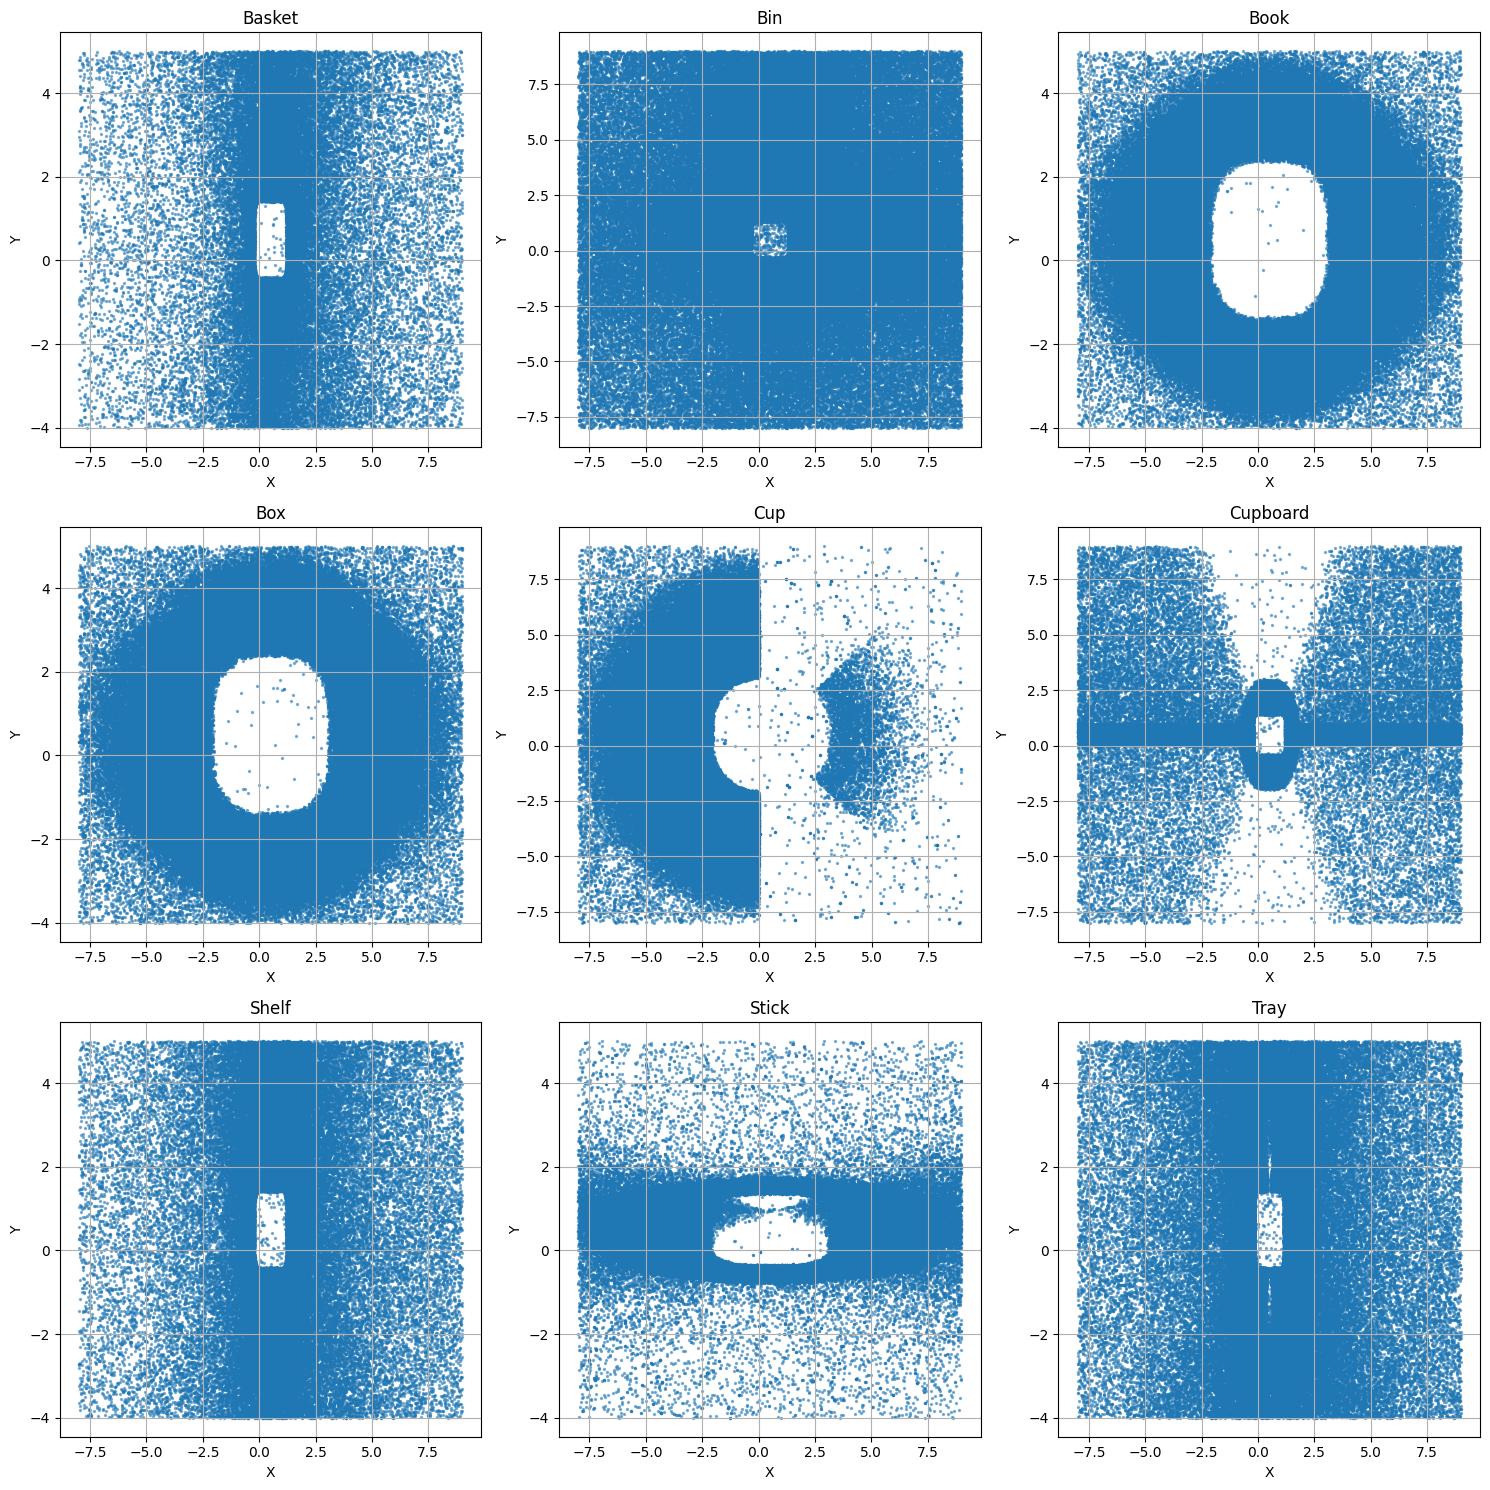

In [40]:
import matplotlib.pyplot as plt

# First, organize all your datasets into a list
dataset_list = [
    basket_data, bin_data, book_data, box_data,
    cupboard_data, shelf_data, stick_data, tray_data
]
dataset_names = [
    "Basket", "Bin", "Book", "Box",
    "Cupboard", "Shelf", "Stick", "Tray"
]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3 rows, 3 columns
axes = axes.flatten()  # flatten to 1D array for easy iteration

# Loop through each dataset
for idx, (data, name) in enumerate(zip(dataset_list, dataset_names)):
    ax = axes[idx]

    # Select columns 10 and 11
    points = data[:, 10:12].cpu().numpy()

    # Plot
    ax.scatter(points[:, 0], points[:, 1], s=2, alpha=0.5)
    ax.set_title(name)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

# Hide any empty subplots (if any)
for j in range(len(dataset_list), len(axes)):
    axes[j].axis('off')

# Adjust spacing
plt.tight_layout()
plt.savefig("robut_original_general_distribution.pdf", bbox_inches='tight')
plt.show()


#### The Specialized Dataset (House)

In [46]:
# Parameters
batch_size_house = 512

ball_data = organize(ball)
(ball_states_train, ball_actions_train, ball_task_idx_train), (ball_states_test, ball_actions_test, ball_task_idx_test) = shuffle_and_split(ball_data, training_size = 30, test_size = 1000, random_seed=42)
check_overlapping(ball_task_idx_train, ball_task_idx_test)

# normalize states
# ball_states_train_norm, ball_states_mean, ball_states_std = normalize_data(ball_states_train, eps=1e-8)
ball_states_train_norm = (ball_states_train - general_states_mean) / general_states_std
ball_states_test_norm = (ball_states_test - general_states_mean) / general_states_std

# normalize actions
# ball_actions_train_norm, ball_actions_mean, ball_actions_std = normalize_data(ball_actions_train, eps=1e-8)
ball_actions_train_norm = (ball_actions_train - general_actions_mean) / general_actions_std
ball_actions_test_norm = (ball_actions_test - general_actions_mean) / general_actions_std

ball_train = torch.hstack((ball_actions_train_norm, ball_states_train_norm))
ball_test = torch.hstack((ball_actions_test_norm, ball_states_test_norm))
print(ball_train.shape)
print(ball_test.shape)

# dataloader
ball_train = ball_train.to(device)
ball_test = ball_test.to(device)
house_dataset = TensorDataset(ball_train)
data_house_loader = DataLoader(house_dataset, batch_size=batch_size_house, shuffle=False)

No overlapping task indices between training and test sets.
torch.Size([442, 12])
torch.Size([13398, 12])


#### house data visualization

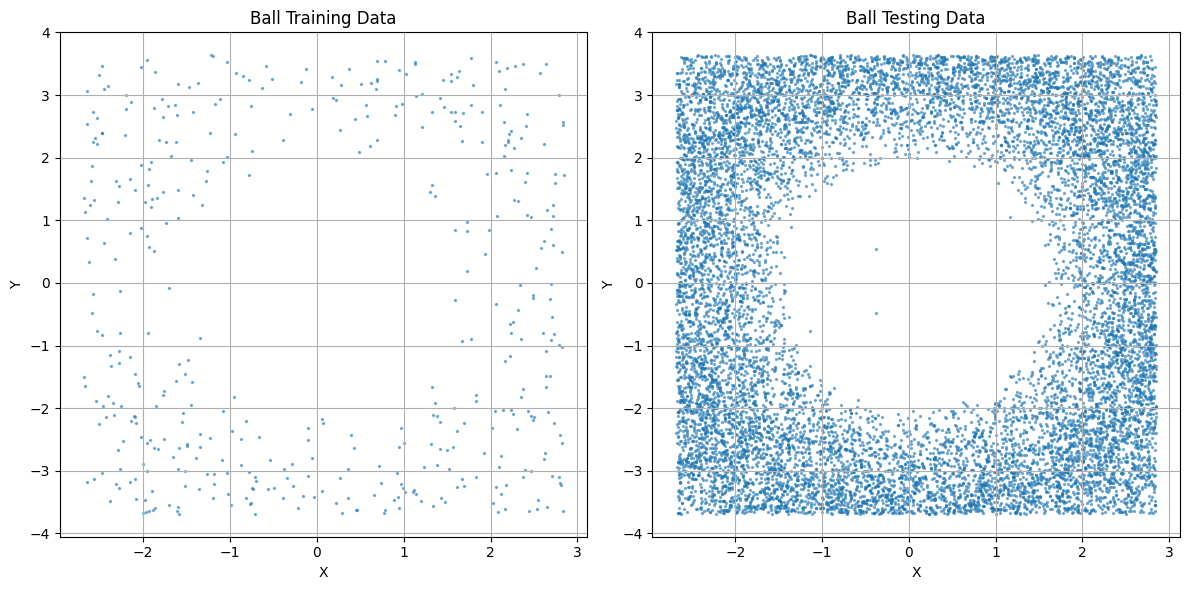

In [47]:
dataset_list = [ball_train, ball_test]
dataset_names = ["Ball Training Data", "Ball Testing Data"]

# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # wider figure for side-by-side plots

for i, ax in enumerate(axes):
    # Select columns 0 and 1 from the dataset
    points = dataset_list[i][:, 0:2].cpu().numpy()

    # Scatter plot
    ax.scatter(points[:, 0], points[:, 1], s=2, alpha=0.5)
    ax.set_title(dataset_names[i])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

# Layout and save
plt.tight_layout()
plt.savefig("robot_house_traintest_distribution.pdf", bbox_inches='tight')
plt.show()

## Define the Diffusion Model

In [10]:
# Model Defined
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x

class DiffusionModel(nn.Module):
    def __init__(self, xfeatures: int, yfeatures: int, nblocks: int = 2, nunits: int = 1024):
        super(DiffusionModel, self).__init__()
        self.inblock = nn.Linear(xfeatures + yfeatures + 1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, yfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:

        val = torch.hstack([x,  t.type(torch.float32)])
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val


def noise(Xbatch, t, baralphas, yfeatures):
    # Edited so that it does not give the device error
    Xbatch = Xbatch.to(device)
    Xbatch_temp = Xbatch[:, 0:yfeatures]
    baralphas = baralphas.to(device)
    # noise function
    eps = torch.randn_like(Xbatch_temp)
    noised = (baralphas[t] ** 0.5).view(-1, 1) * Xbatch_temp + ((1 - baralphas[t]) ** 0.5).view(-1, 1) * eps
    noised = torch.hstack([noised, Xbatch[:, yfeatures:]])
    return noised, eps

### Noising Parameters

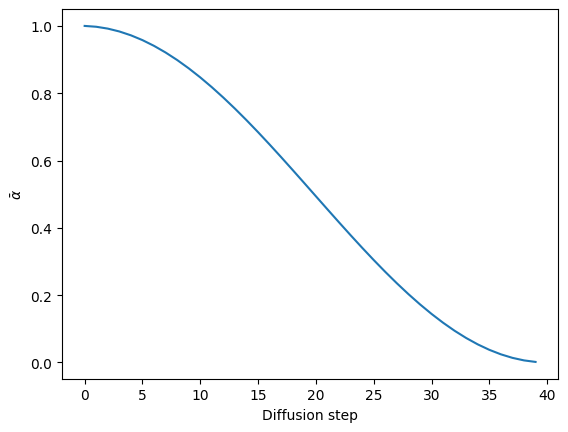

In [11]:
# Define parameters
nepochs = 100

diffusion_steps = 40
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * np.pi / 2) ** 2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.cat([baralphas[:1], baralphas[:-1]])
alphas = 1 - betas

sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

### Training Algorithm

In [12]:
# Initialize
loss_fn = nn.MSELoss()

def train_model(model, data_loader, loss_fn, nepochs, loss_values,
                diffusion_steps, baralphas, device, batch_size, yfeatures):

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    model.train()

    for epoch in range(nepochs):
        epoch_loss = 0
        for batch in data_loader:
            Xbatch = batch[0].to(device)
            Xbatch = Xbatch.type(torch.float32)

            timesteps = torch.randint(0, diffusion_steps, (len(Xbatch),), dtype=torch.long).to(device)
            noised, eps = noise(Xbatch, timesteps, baralphas, yfeatures)

            predicted_noise = model(noised, timesteps.unsqueeze(-1).type(torch.float32))

            loss = loss_fn(predicted_noise, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)
        loss_values.append(avg_loss)

        scheduler.step()  # Update scheduler after each epoch

    return loss_values


### Generate Samples Algorithm

In [13]:
def sample_generate(model, nsamples, input, yfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    assert len(input) == 10, "input must contain exactly 10 inputs"
    assert input.dtype == torch.float32, "input must be a float32 tensor"
    # Convert all inputs to tensors and move to device
    x_tensors = [torch.tensor(xi).to(device) for xi in input]

    # Repeat each input tensor to match nsamples
    x_tensors = [xi.repeat(nsamples, 1) for xi in x_tensors]

    # Concatenate all inputs along the feature axis
    x_combined = torch.hstack(x_tensors)

    with torch.no_grad():
        X = torch.randn(size=(nsamples, yfeatures)).to(device)
        X_comb = torch.hstack((X, x_combined))
        Xt = [X]
        for t in range(diffusion_steps-1, 0, -1):
            timestep_tensor = torch.full((nsamples, 1), t, dtype=torch.long, device=device)
            predicted_noise = model(X_comb, timestep_tensor)
            X = 1 / (alphas[t] ** 0.5) * (X - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            X_comb = torch.hstack((X, x_combined))
            if t > 1:
                variance = betas[t]
                std = variance ** (0.5)
                X += std * torch.randn(size=(nsamples, yfeatures)).to(device)
            Xt += [X]
        return X, Xt

# This is designed only for generating samples from joint distributions
def sample_joint_generate(model1, model2, nsamples, input, yfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    assert len(input) == 10, "input must contain exactly 10 different inputs"
    assert input.dtype == torch.float32, "input must be a float32 tensor"
    # Convert all inputs to tensors and move to device
    x_tensors = [torch.tensor(xi).to(device) for xi in input]

    # Repeat each input tensor to match nsamples
    x_tensors = [xi.repeat(nsamples, 1) for xi in x_tensors]

    # Concatenate all inputs along the feature axis
    x_combined = torch.hstack(x_tensors)

    with torch.no_grad():
        X = torch.randn(size=(nsamples, yfeatures)).to(device)
        X_comb = torch.hstack((X, x_combined))
        Xt = [X]
        for t in range(diffusion_steps-1, 0, -1):
            timestep_tensor = torch.full((nsamples, 1), t, dtype=torch.long, device=device)
            predicted_noise = model1(X_comb, timestep_tensor) + model2(X_comb, timestep_tensor)
            X = 1 / (alphas[t] ** 0.5) * (X - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            X_comb = torch.hstack((X, x_combined))
            if t > 1:
                variance = betas[t]
                std = variance ** (0.5)
                X += std * torch.randn(size=(nsamples, yfeatures)).to(device)
            Xt += [X]
        return X, Xt

## Training

Training the world model

Model of World Data:
DiffusionModel(
  (inblock): Linear(in_features=13, out_features=1024, bias=True)
  (midblocks): ModuleList(
    (0-4): 5 x DiffusionBlock(
      (linear): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (outblock): Linear(in_features=1024, out_features=2, bias=True)
)


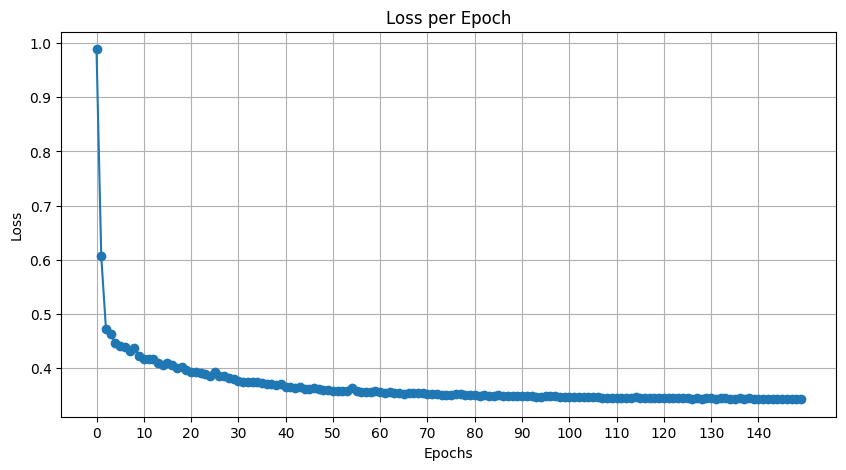

In [55]:
# Define Models
# Model trained only on the world data
model_world = DiffusionModel(xfeatures = 10, yfeatures = 2, nblocks=5)
model_world = model_world.to(device)
print("Model of World Data:")
print(model_world)

nepochs = 150
loss_values_world = []
train_model(model_world, data_world_train_loader, loss_fn, nepochs,
            loss_values_world, diffusion_steps, baralphas, device, batch_size_world, yfeatures=2)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs), loss_values_world, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs, 10))
plt.show()

Training the House model

Model of House Data:
DiffusionModel(
  (inblock): Linear(in_features=13, out_features=1024, bias=True)
  (midblocks): ModuleList(
    (0-4): 5 x DiffusionBlock(
      (linear): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (outblock): Linear(in_features=1024, out_features=2, bias=True)
)


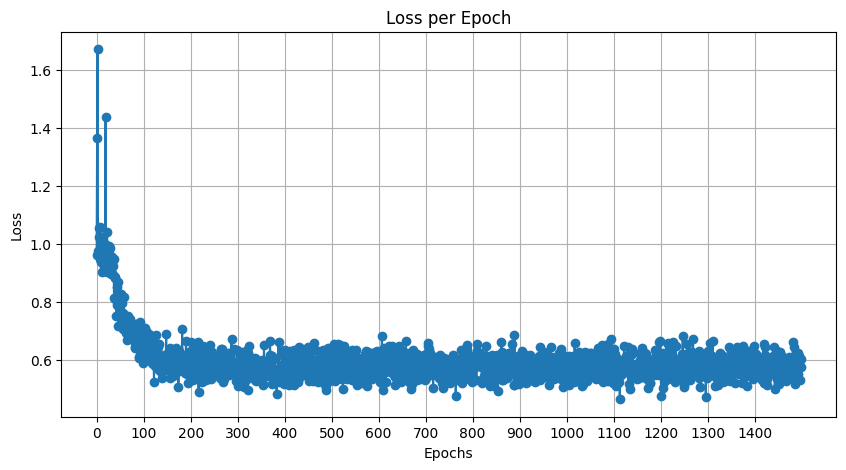

In [48]:
# Model trained only on the house data (This model is expected to be a bad model)
model_house = DiffusionModel(xfeatures = 10, yfeatures = 2, nblocks=5)
model_house = model_house.to(device)
print("Model of House Data:")
print(model_house)
nepochs_house = 1500

loss_values_house = []
train_model(model_house, data_house_loader, loss_fn, nepochs_house,
            loss_values_house, diffusion_steps, baralphas, device, batch_size_house, yfeatures=2)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs_house), loss_values_house, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs_house, 100))
plt.show()

Training Finetuned model


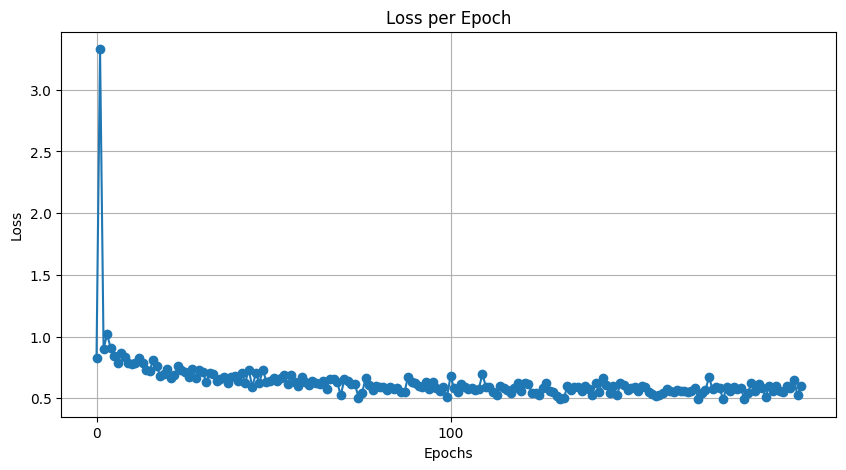

In [56]:
# Create a new model instance
model_finetune = DiffusionModel(xfeatures = 10, yfeatures = 2, nblocks=5)
model_finetune = model_finetune.to(device)

# Copy the trained weights from model_world
model_finetune.load_state_dict(model_world.state_dict())

# Now, fine-tune model_other on the new dataset
nepochs_finetune = 200
loss_values_finetune = []
train_model(model_finetune, data_house_loader, loss_fn, nepochs_finetune,
            loss_values_finetune, diffusion_steps, baralphas, device, batch_size_house, yfeatures=2)
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, nepochs_finetune), loss_values_finetune, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(ticks=range(0, nepochs_finetune, 100))
plt.show()

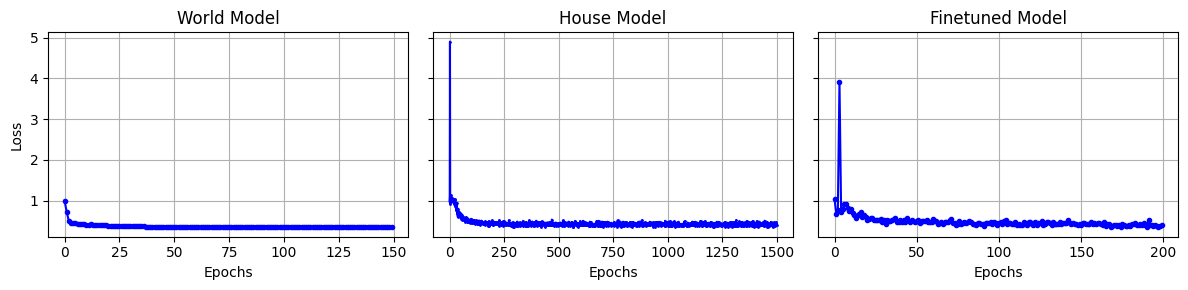

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# Plot World Model Loss
axes[0].plot(range(0, nepochs), loss_values_world, color='blue', marker='o', markersize=3)
axes[0].set_title('World Model')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Plot House Model Loss
axes[1].plot(range(0, nepochs_house), loss_values_house, color='blue', marker='o', markersize=1)
axes[1].set_title('House Model')
axes[1].set_xlabel('Epochs')
axes[1].grid(True)

# Plot Joint Model Loss
axes[2].plot(range(0, nepochs_finetune), loss_values_finetune, color='blue', marker='o', markersize=3)
axes[2].set_title('Finetuned Model')
axes[2].set_xlabel('Epochs')
axes[2].grid(True)

# Tight layout to avoid overlap
plt.savefig("robotic_Training.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

## Save the trained model parameters

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Save models
# torch.save(model_world, '/content/drive/My Drive/DiffusionModel/Experiment/Saved Models/world_model_minmax.pth')
# torch.save(model_house, '/content/drive/My Drive/DiffusionModel/Experiment/Saved Models/house_model_minmax.pth')
# torch.save(model_finetune, '/content/drive/My Drive/DiffusionModel/Experiment/Saved Models/finetune_model_minmax.pth')

# Load models
# model_world = torch.load('/content/drive/My Drive/DiffusionModel/Experiment/Saved Models/world_model.pth', weights_only=False)
# model_house = torch.load('/content/drive/My Drive/DiffusionModel/Experiment/Saved Models/house_model.pth', weights_only=False)
# model_finetune = torch.load('/content/drive/My Drive/DiffusionModel/Experiment/Saved Models/finetune_model.pth', weights_only=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualization of all the results

### Check joint

In [57]:
ball_test_point = ball_test[:, 2:12]
ball_test_answer = ball_test[:, 0:2]

# generate samples
all_world = []
all_hosue = []
all_joint = []
all_finetune = []
all_joint_finetune = []

In [58]:
for i in range(ball_test_point.shape[0]):
    final_samples_world, all_samples_world = sample_generate(model_world, nsamples=1, input=ball_test_point[i], yfeatures=2)
    all_world.append(final_samples_world)

<ipython-input-13-1a6435a1b89d>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensors = [torch.tensor(xi).to(device) for xi in input]


In [59]:
for i in range(ball_test_point.shape[0]):
    final_samples_house, all_samples_house = sample_generate(model_house, nsamples=1, input=ball_test_point[i], yfeatures=2)
    all_hosue.append(final_samples_house)

<ipython-input-13-1a6435a1b89d>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensors = [torch.tensor(xi).to(device) for xi in input]


In [60]:
for i in range(ball_test_point.shape[0]):
    final_samples_finetune, all_samples_finetune = sample_generate(model_finetune, nsamples=1, input=ball_test_point[i], yfeatures=2)
    all_finetune.append(final_samples_finetune)

<ipython-input-13-1a6435a1b89d>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensors = [torch.tensor(xi).to(device) for xi in input]


In [61]:
for i in range(ball_test_point.shape[0]):
    final_samples_joint, all_samples_joint = sample_joint_generate(model_house, model_world, nsamples=1, input=ball_test_point[i], yfeatures=2)
    all_joint.append(final_samples_joint)

<ipython-input-13-1a6435a1b89d>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensors = [torch.tensor(xi).to(device) for xi in input]


In [62]:
for i in range(ball_test_point.shape[0]):
    final_samples_joint_finetune, all_samples_joint_finetune = sample_joint_generate(model_finetune, model_world, nsamples=1, input=ball_test_point[i], yfeatures=2)
    all_joint_finetune.append(final_samples_joint_finetune)

<ipython-input-13-1a6435a1b89d>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensors = [torch.tensor(xi).to(device) for xi in input]


In [63]:
# Convert tensors to numpy for plotting
final_world = torch.vstack(all_world)
final_house = torch.vstack(all_hosue)
final_joint = torch.vstack(all_joint)
final_finetune = torch.vstack(all_finetune)
final_joint_finetune = torch.vstack(all_joint_finetune)

final_world_np = final_world.cpu().numpy()
final_house_np = final_house.cpu().numpy()
final_finetune_np = final_finetune.cpu().numpy()
final_joint_np = final_joint.cpu().numpy()
final_joint_finetune_np = final_joint_finetune.cpu().numpy()
test_answer_np = ball_test_answer.cpu().numpy()

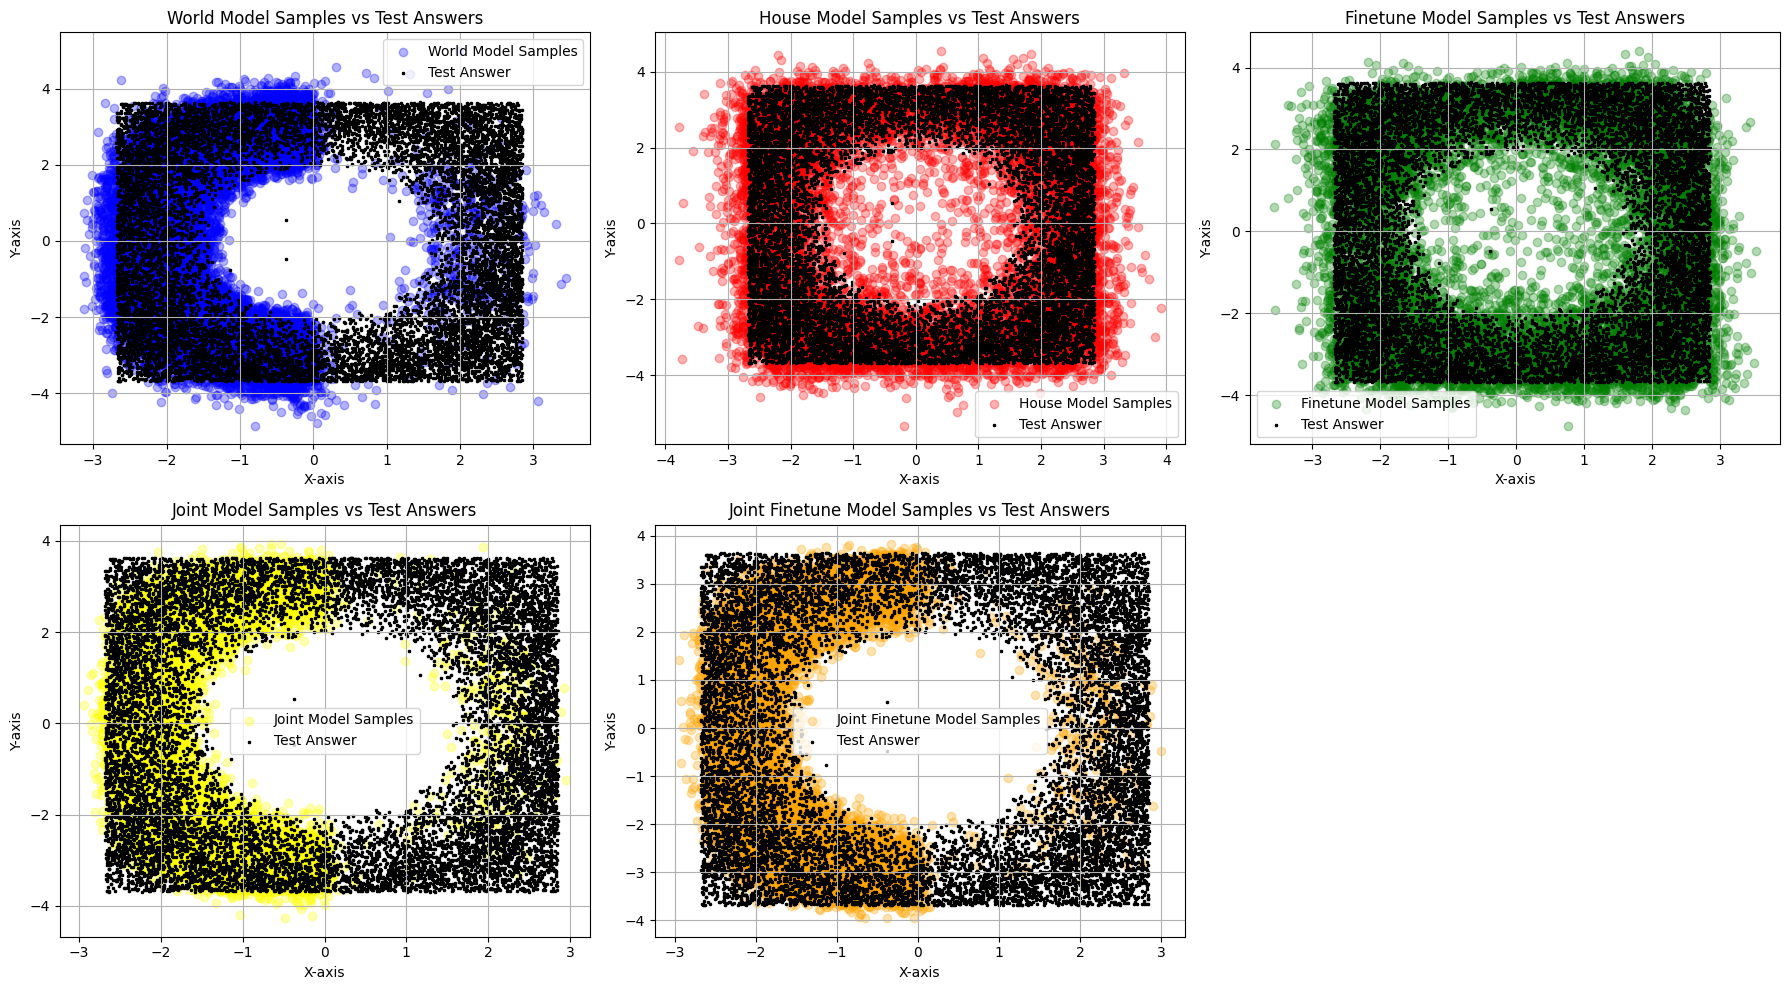

In [64]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create a PDF to save the combined plot
with PdfPages("robot_sampling_visualization.pdf") as pdf:
    # Define datasets: (data, color, label)
    datasets = [
        (final_world_np, 'blue', "World Model Samples"),
        (final_house_np, 'red', "House Model Samples"),
        (final_finetune_np, 'green', "Finetune Model Samples"),
        (final_joint_np, 'yellow', "Joint Model Samples"),
        (final_joint_finetune_np, 'orange', "Joint Finetune Model Samples")
    ]

    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Wider to fit 3 plots per row
    axes = axes.flatten()  # Flatten to access by index

    for idx, (data, color, label) in enumerate(datasets):
        ax = axes[idx]
        ax.scatter(data[:, 0], data[:, 1], color=color, label=label, alpha=0.3)
        ax.scatter(test_answer_np[:, 0], test_answer_np[:, 1],
                   color='black', marker='x', s=3, label="Test Answer")
        ax.set_title(f"{label} vs Test Answers")
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.grid(True)
        ax.legend()

    # Hide any unused subplot (in this case, the 6th one)
    if len(datasets) < len(axes):
        for j in range(len(datasets), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig("robotic_result.pdf", bbox_inches='tight')
    plt.show()

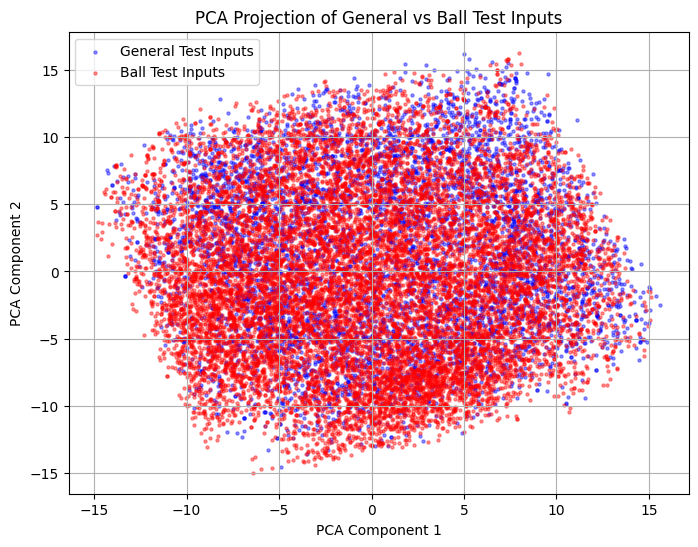

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume these two are already your input tensors (before normalization!)
# general_states_test: (N1, 10)
# ball_test_point: (N2, 10)

# Move to CPU if needed
general_states_test_cpu = general_states_test.cpu()
ball_states_test_cpu = ball_states_test.cpu()

# Stack them together
all_inputs = torch.vstack([general_states_test_cpu, ball_states_test_cpu])

# Create labels (0 for General, 1 for Ball)
labels = torch.cat([
    torch.zeros(general_states_test_cpu.shape[0]),
    torch.ones(ball_states_test_cpu.shape[0])
])

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_inputs.numpy())

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    pca_result[labels == 0, 0], pca_result[labels == 0, 1],
    color='blue', alpha=0.4, label='General Test Inputs', s=5
)
plt.scatter(
    pca_result[labels == 1, 0], pca_result[labels == 1, 1],
    color='red', alpha=0.4, label='Ball Test Inputs', s=5
)
plt.legend()
plt.title("PCA Projection of General vs Ball Test Inputs")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


###(1) check the general model

In [ ]:
# Select the features and answers using these indices
general_test_point = general_test[:, 2:12]
general_test_answer = general_test[:, :2].cpu().numpy()

all_world = []
for i in range(general_test_point.shape[0]):

    # World Model
    final_samples_world, all_samples_world = sample_generate(model_world, nsamples=1, input=general_test_point[i], yfeatures=2)
    all_world.append(final_samples_world)

final_world = torch.vstack(all_world).cpu().numpy()

<ipython-input-14-1a6435a1b89d>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensors = [torch.tensor(xi).to(device) for xi in input]


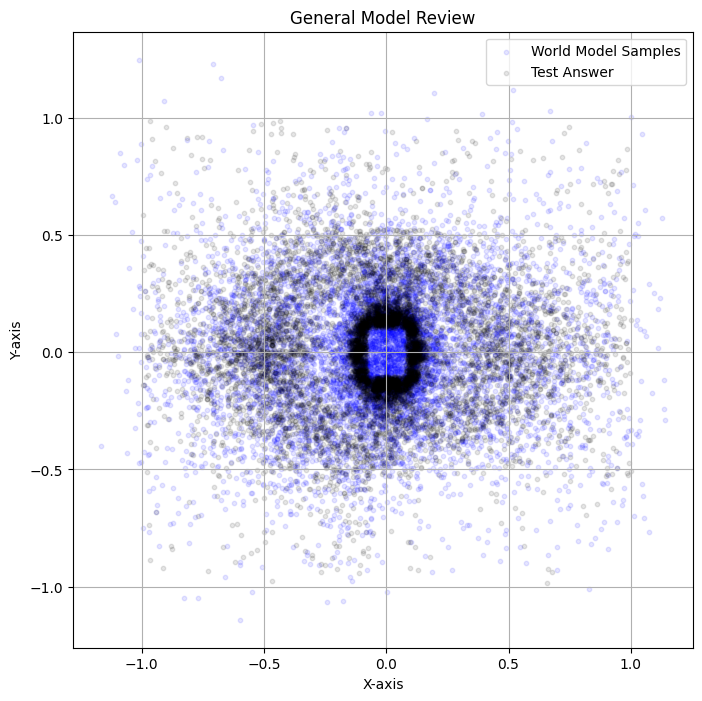

In [ ]:
# Create the figure
plt.figure(figsize=(8, 8))

# Plot each set of samples
plt.scatter(final_world[:, 0], final_world[:, 1],
            color='blue', s = 10, label="World Model Samples", alpha=0.1)

# Plot the test answer
plt.scatter(general_test_answer[:, 0], general_test_answer[:, 1],
            color='black', marker = 'o', s = 10, label="Test Answer", alpha = 0.1)

# Add labels, title, and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("General Model Review")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()